## Training a PyTorch Model for Image Classification

In this notebook we will create an image classifier to detect playing cards. Almost every pytorch model training pipeline meets this paradigm.

We will tackle this problem in 3 parts:
- Pytorch Dataset: understanding how to create PyTorch Dataset and DataLoaders to efficiently load and preprocess image data.
- Pytorch Model: defining the neural network architecture using PyTorch’s nn.Module.
- Pytorch Training Loop: implementing the training and evaluation loop, including forward passes, loss computation, backpropagation, and optimization

Project Setup
- The project is implemented in Kaggle, so a high-end GPU is not required.
- The dataset is organized as folders, where each folder corresponds to a different playing card class and contains images of that card.

Goal:

The objective is to train a model that can take an input image of a playing card and accurately classify which card it represents.


In [24]:
## importing all packages needed

import torch
import torch.nn as nn ## all specific functions related to neural networks
import torch.optim as optim ## defines optimizer
from torch.utils.data import Dataset, DataLoader ## first step in process
import torchvision ## tools for image datasets, transforms, and models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd ## data exploration
import numpy as np ## data exploration
import sys
from tqdm.notebook import tqdm ## shows progress bar as training

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)


## to get rid of unneccessary warnings 
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module="pydantic")


System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 1.26.4
Pandas version 2.2.3


## Step 1. Pytorch Dataset (and Dataloader)

First, we need to have the dataset setup correctly.

Why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [26]:
## setting up dataset b/c that is how PyToch is going to load in data as it trains and evaluates model
## PyTorch datasets are flexible and can be wrapped with DataLoaders for parallel, batched loading


## we create this dataset by creating a python class: PlayingCardDataset
## this will inherit from PyTorch dataset imported above 

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None): ## what to do when created .. we want to take data directry and transform
        self.data = ImageFolder(data_dir, transform=transform) 
    
    def __len__(self): ## data loader needs to know how many exampless we have, returns length
        return len(self.data)
    
    def __getitem__(self, idx): ## takes index location and returns an item
        return self.data[idx]

    ## makes it easier to find classname, returns data classes from image folder
    @property 
    def classes(self):
        return self.data.classes

## Create Test Dataset

In [27]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification/train'
)

In [28]:
## testing length method on data length
len(dataset) 

7624

41


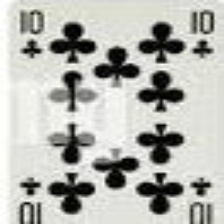

In [29]:
## testing if index returns class/number of card and image

image, label = dataset[6000]
print(label)
image

In [30]:
## Gets a dictionary associating target values with folder names
## ie 41 is ten of clubs as seen above so dict links each number with correct label/card

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [33]:
## Image outputs must be same size as model will expect the input to always be consistent
## Hence adding a simple transform to resize each image to a fixed size

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [34]:
## Viewing the image tensor shape
## First value is the number of channels (e.g., RGB), remaining values are the image dimensions

image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [35]:
## iterate over dataset
for image, label in dataset:
    break

Recap:
- Creating a PyTorch Dataset is key
- We can wrap it with a DataLoader to automatically handle batching and parallel image loading


## Dataloaders
- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [36]:
## Setting up the DataLoader
## batch_size defines how many examples to load at a time in iteration
## shuffle randomly shuffles data each epoch (optional)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [37]:
for images, labels in dataloader:
    break

In [38]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [39]:
## each time we run this, we get diff output 
labels

tensor([16, 42, 40, 42, 11, 36, 26, 10, 43, 29, 26, 25, 18, 38, 11, 10, 24, 23,
        16, 15, 26, 46, 46,  7,  1, 49, 11, 50,  6,  3, 21, 36])

Recap:
- Create a PyTorch Dataset before we train the model by inheriting from Dataset class and implementing methods like __len__ and __getitem__. This makes the dataset iterable which we can loop over.
- Wrap the Dataset with a DataLoader to handle batching and optional shuffling. Feeding batches to the model speeds up training compared to one example at a time.



## Step 2. Pytorch Model
Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.

- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.

In [46]:
## We will use a predefined architecture and import it from library Tim for image classification.

class SimpleCardClassifer(nn.Module): ## imports from neural network module of PyTorch
    def __init__(self, num_classes): 
        ## here we define all parts of the model
        super(SimpleCardClassifer, self).__init__() 

        self.base_model = timm.create_model(
            'efficientnet_b0', ## architecture which trains fast .. size is b0 
            pretrained=False   
        )

        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) 
        
        ## Classifier; linear layer mapping EfficientNet output size to the number of classes
        self.classifier = nn.Linear(self.base_model.num_features, num_classes) 

    def forward(self, x):
        ## here we take in example batch and connect all above parts and return the output
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [47]:
## example to show structure of model above
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [48]:
## test model that input/output are what expect
example_out = model(images)
example_out.shape 

## returns [batch_size, num_classes]

torch.Size([32, 53])

Recap of the model we created:
- Model imported from PyTorch neural network (nn) module
- Defined methods __init__ (model structure) and __forward__ (how data flows through model layers to produce output)
- Tested forward by passing example images from the DataLoader

## Step 3. The training loop
- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
  - Terms:
    - Epoch: One run through the entire training dataset.
    - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, adam is the best place to start for most tasks.
    - loss function: What the model will optimize for.

Idea: feed training data into the model many times, compute a loss on the output, and update the model to learn
- We do this in batches (handled by the DataLoader)
- One epoch = passing through all batches in the training set
- Keep the training loop simple, then choose the optimizer and loss function


In [49]:
## selecting loss function and opitimizer we want to use

## Loss function
## classfification task so use CrossEntropyLoss for this case
criterion = nn.CrossEntropyLoss()

## Optimizer
## Adam, commonly used and works well in most cases for training neural networks
optimizer = optim.Adam(model.parameters(), lr=0.001) ## learnign rate constant of 0.001

In [50]:
## testing loss function 
## example output from model before and labels for that data

criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

In [51]:
## transform resizes images as before

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test/'

## created train and validation dataset based on fodlers above 
train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

## data loaders for each with batch size of 32
## only train loader gets data shuffled as defined above 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [ ]:
## Simple training loop

num_epochs = 5 ## one run through entire training dataset 
train_losses, val_losses = [], [] ## store training and validation losses

## want loop model and data to run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## loop through 5 different epochs
for epoch in range(num_epochs):
 # Training phase
    model.train()
    running_loss = 0.0 ## keep track of loss
    for images, labels in tqdm(train_loader, desc='Training loop'): ## loop through training data loader
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device) 
        
        optimizer.zero_grad() 
        outputs = model(images) ## call forward method on images
        loss = criterion(outputs, labels) ## calculate loss by criteria defined above
        loss.backward() ## update models weight 
        optimizer.step() 
        running_loss += loss.item() * labels.size(0) ## keep track of running loss
    train_loss = running_loss / len(train_loader.dataset) 
    train_losses.append(train_loss) ## store training loss
    
 # Validation phase
    model.eval() ## changing model to evaluation mode from training
    running_loss = 0.0
    with torch.no_grad(): ## ensure model weights are not touched
        for images, labels in tqdm(val_loader, desc='Validation loop'): ## wrapped tqdm to see progress bar as it runs each training and validation loop
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

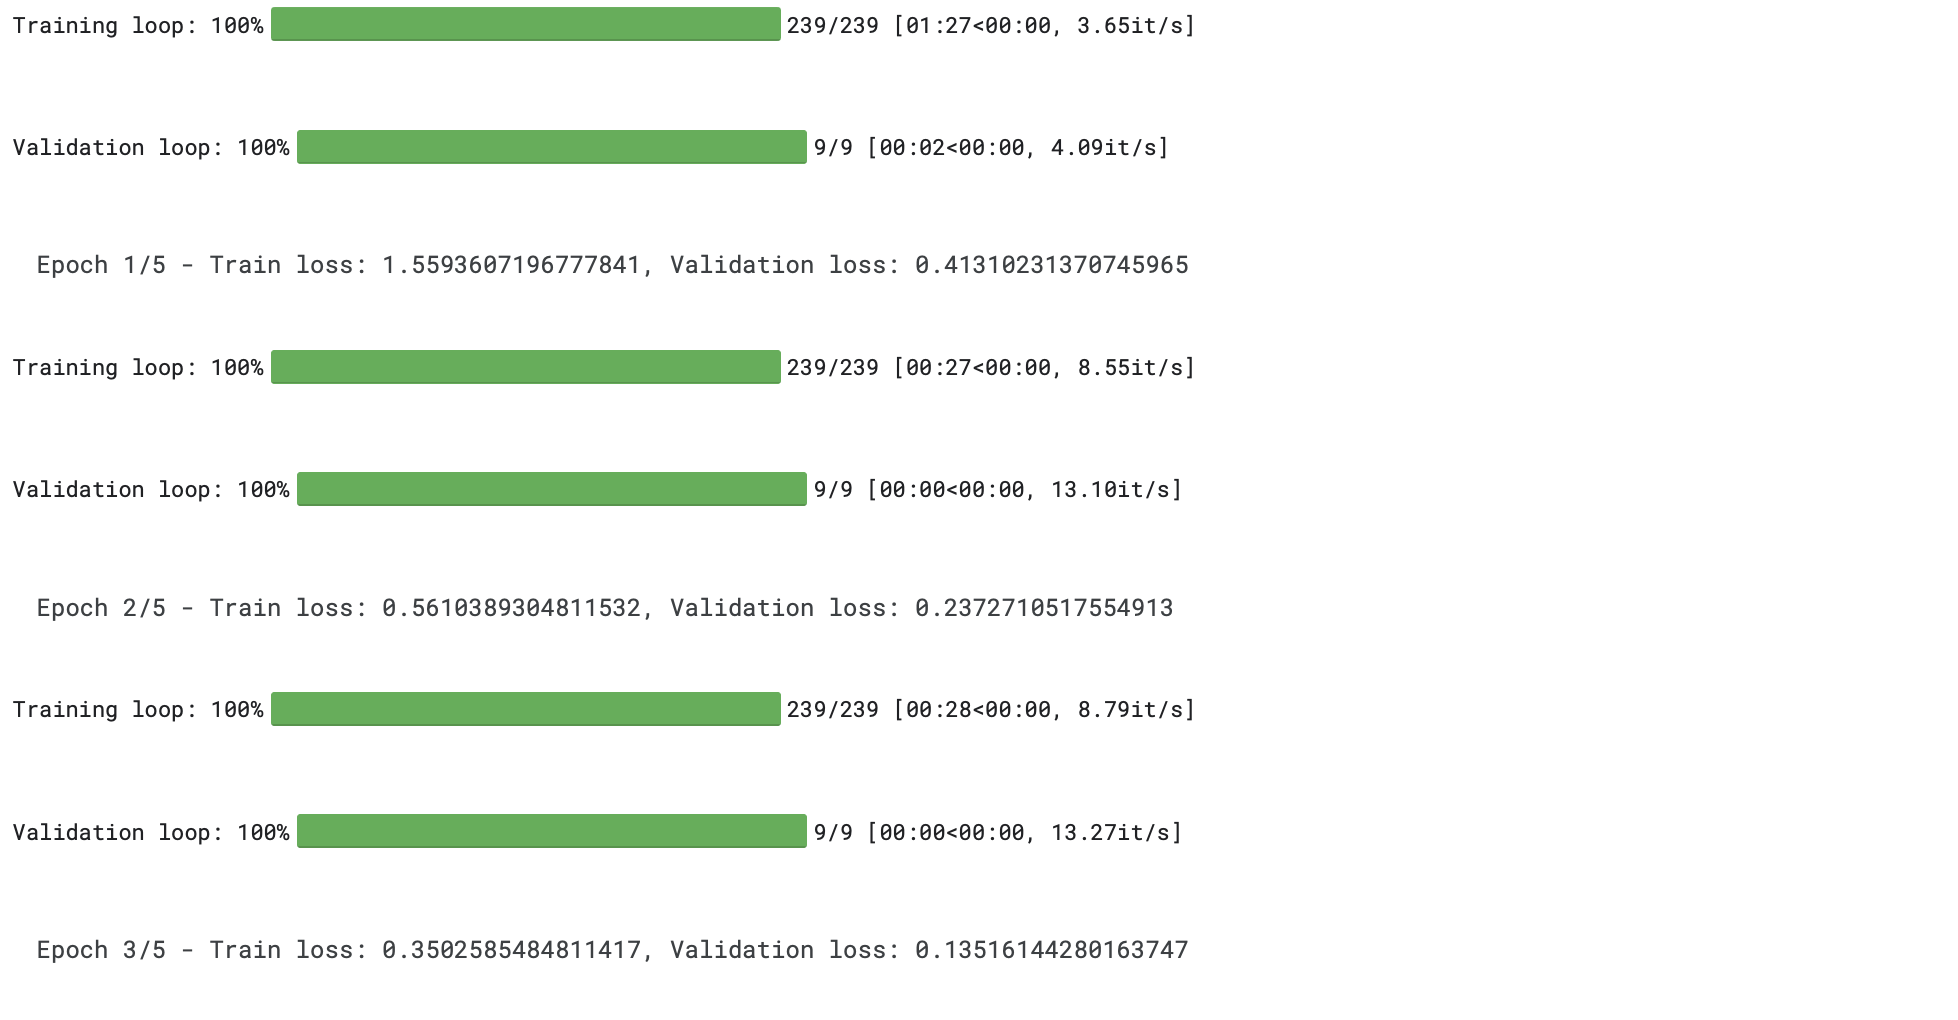
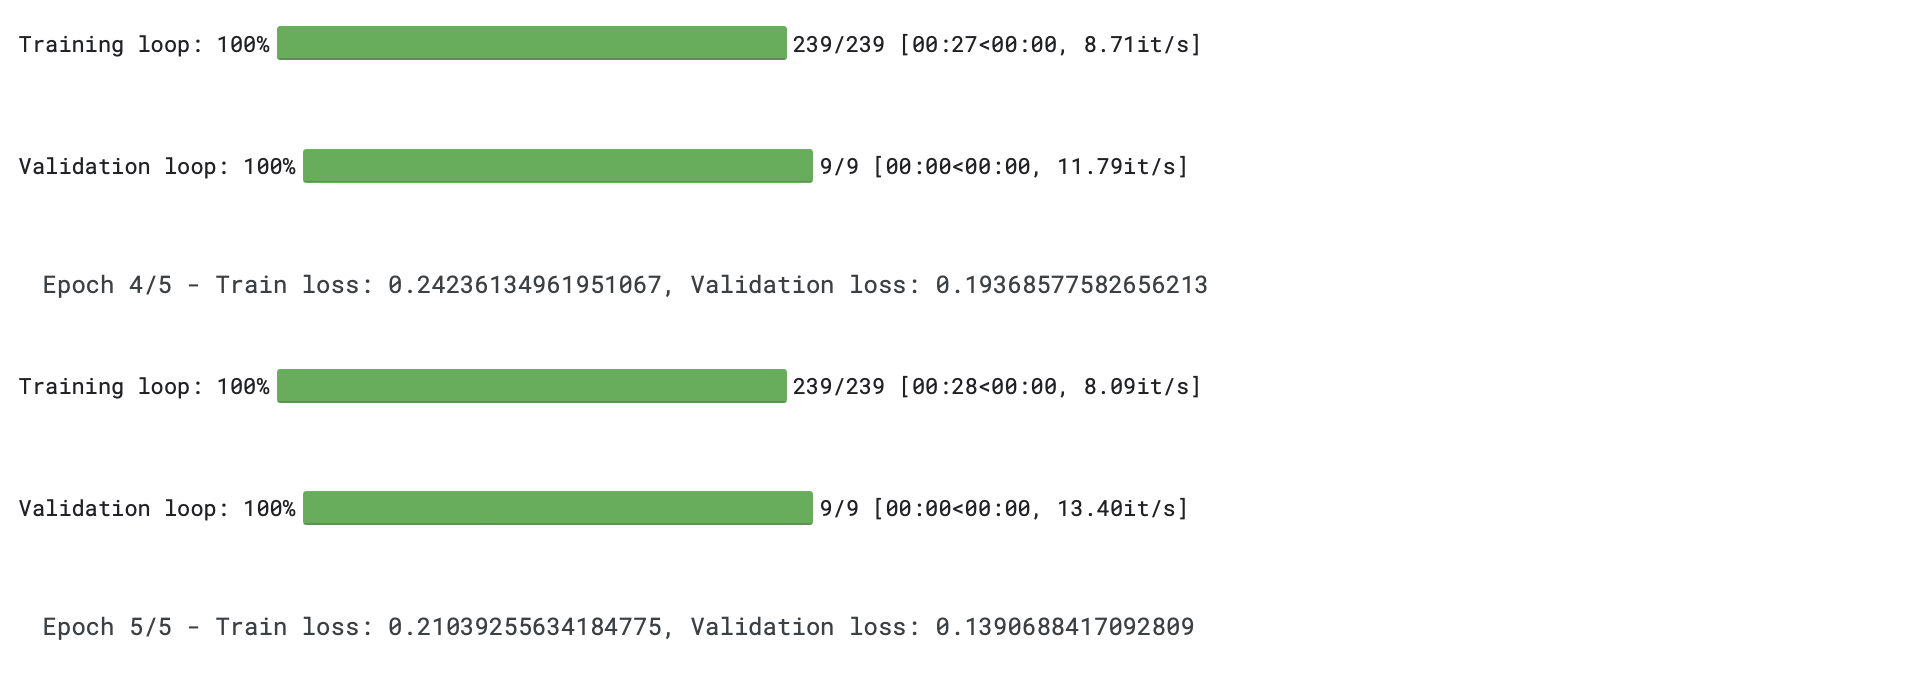
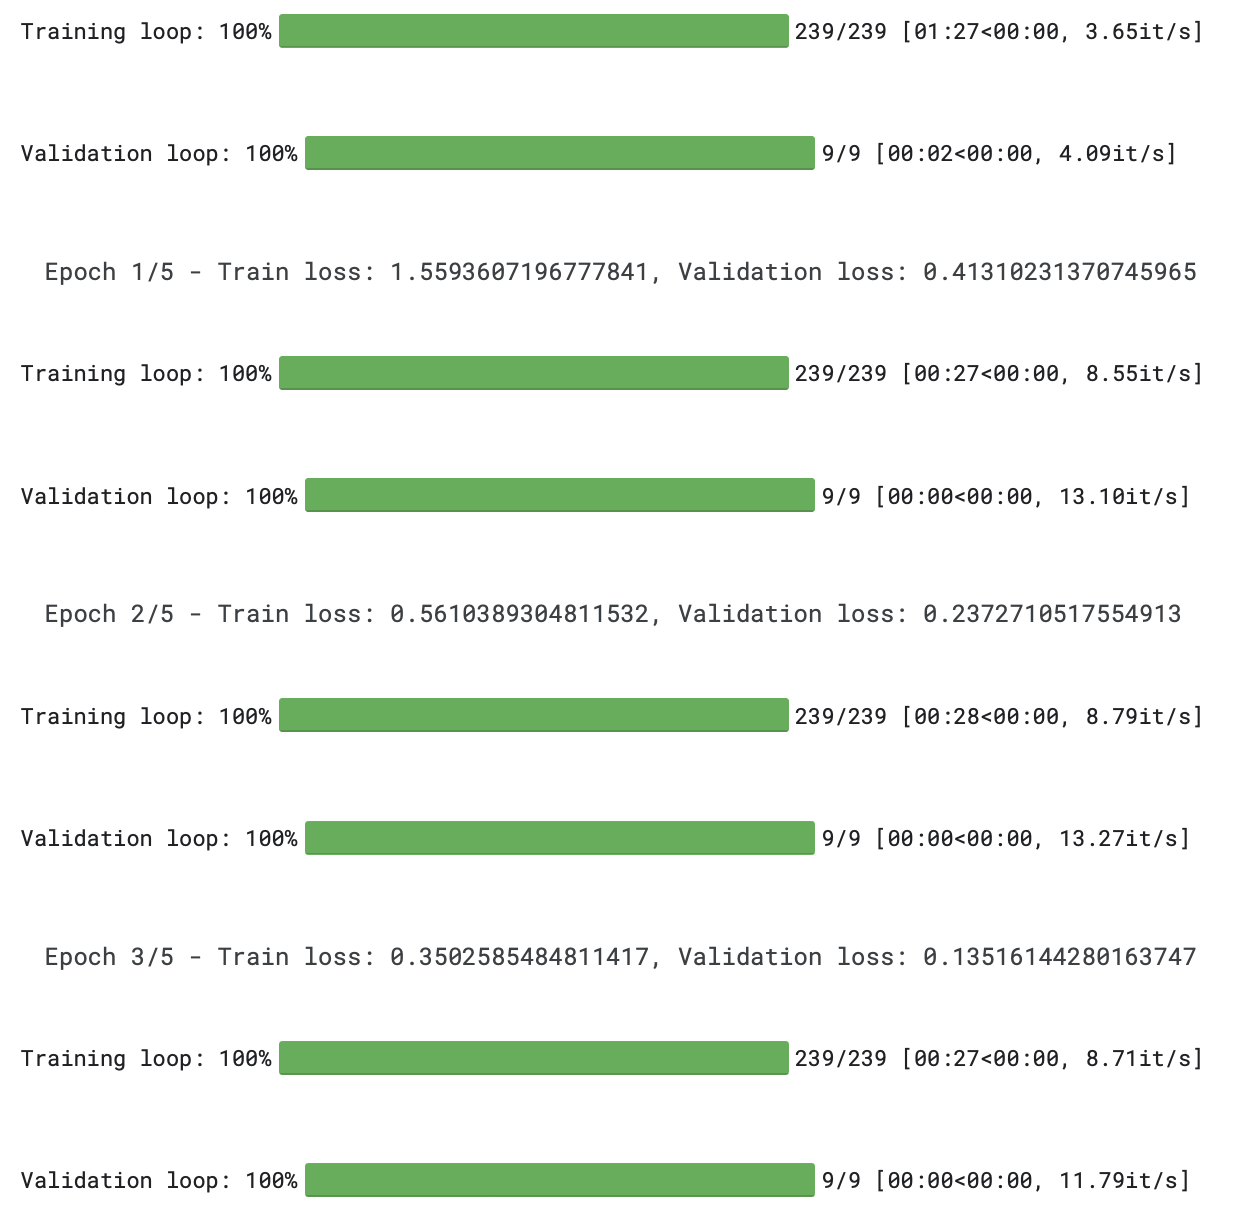
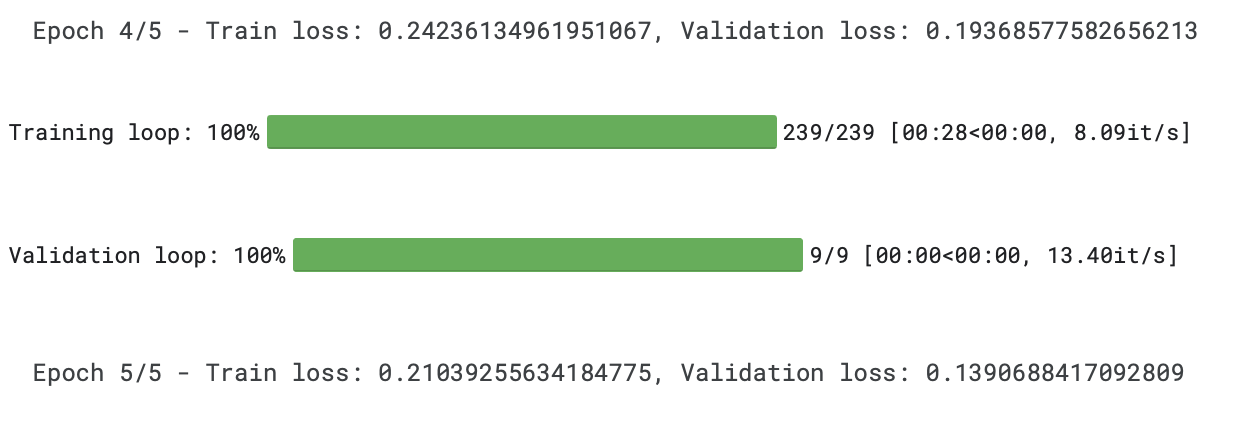
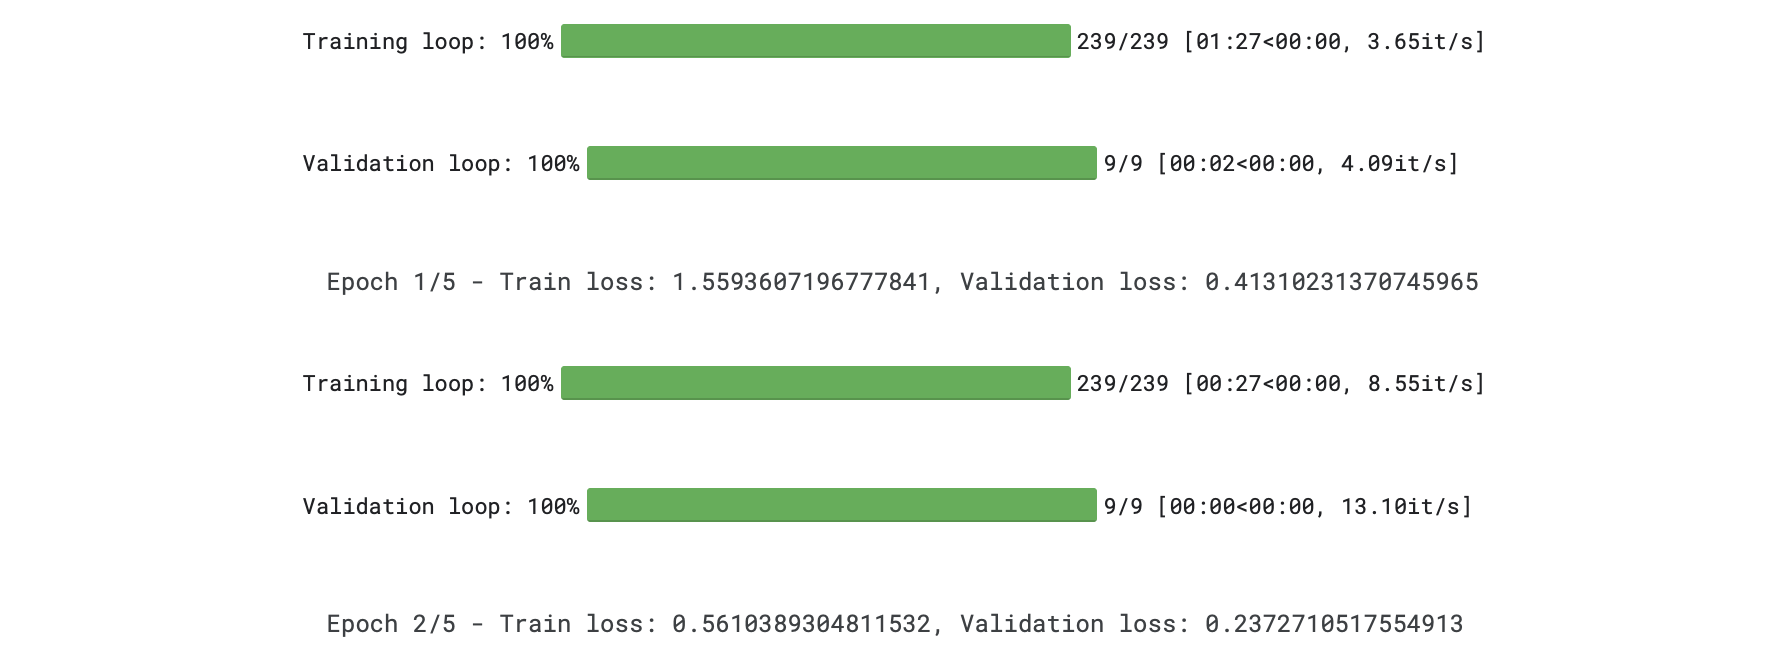
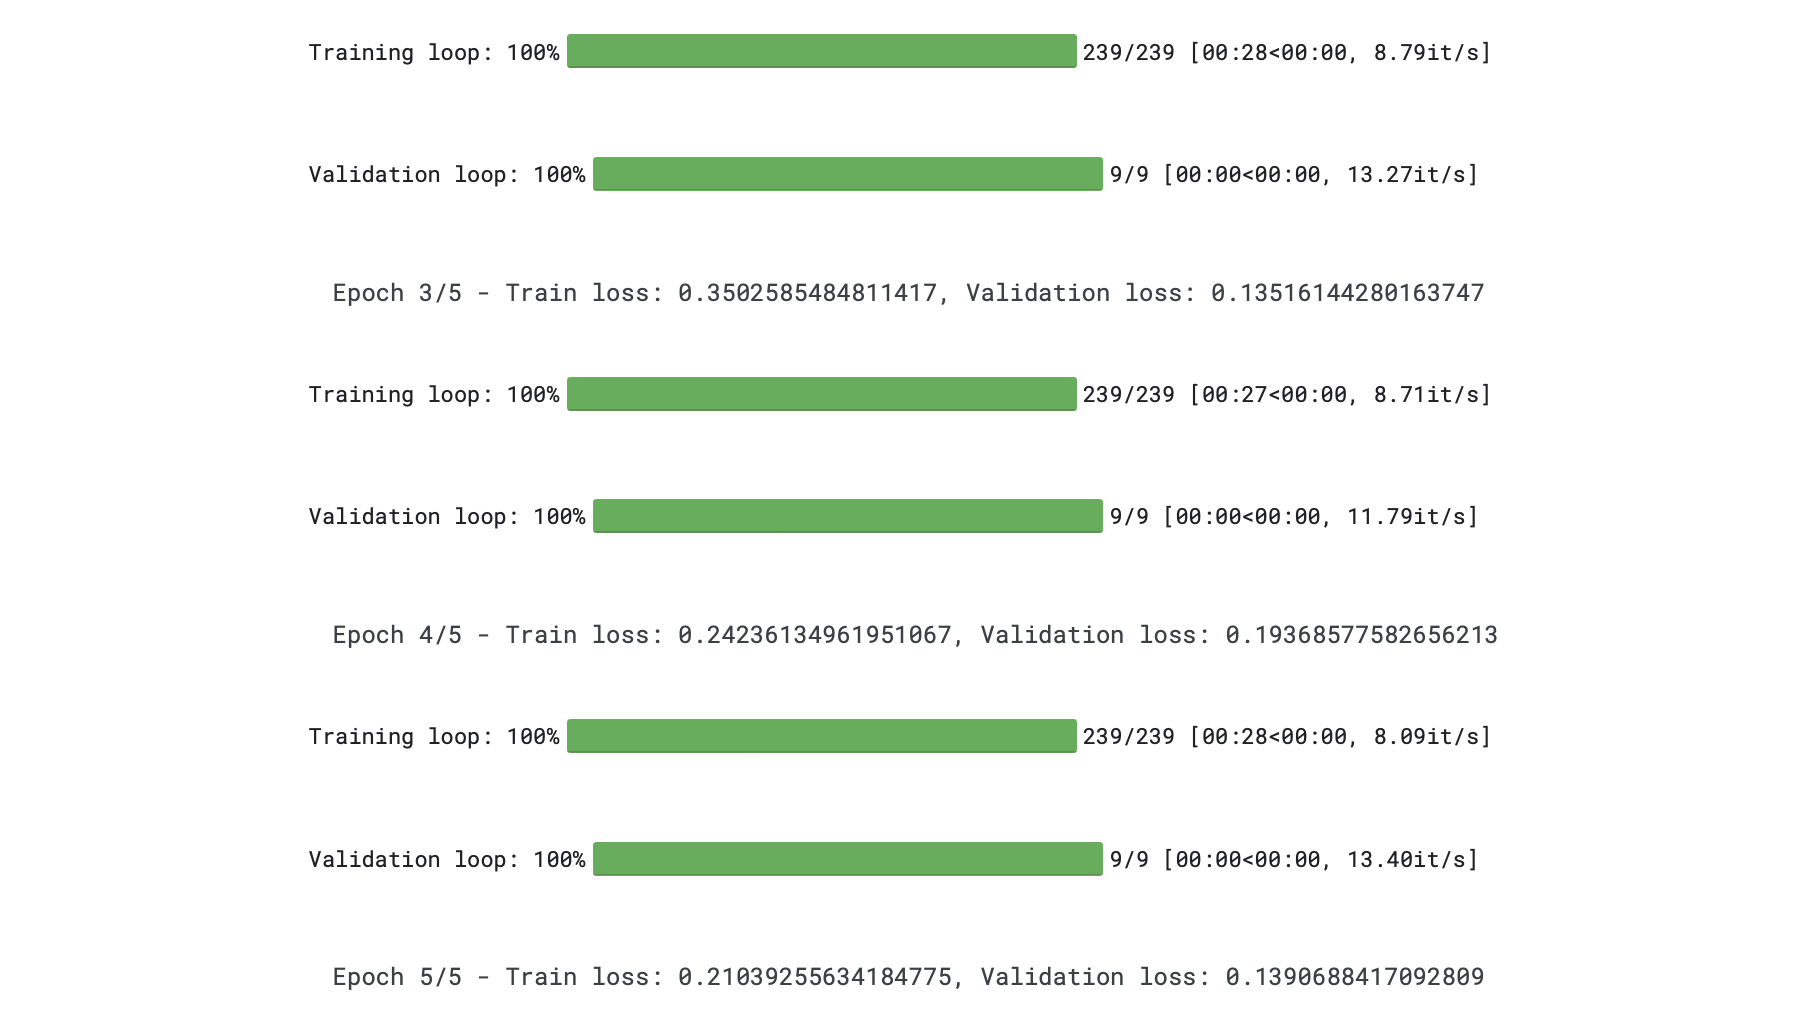
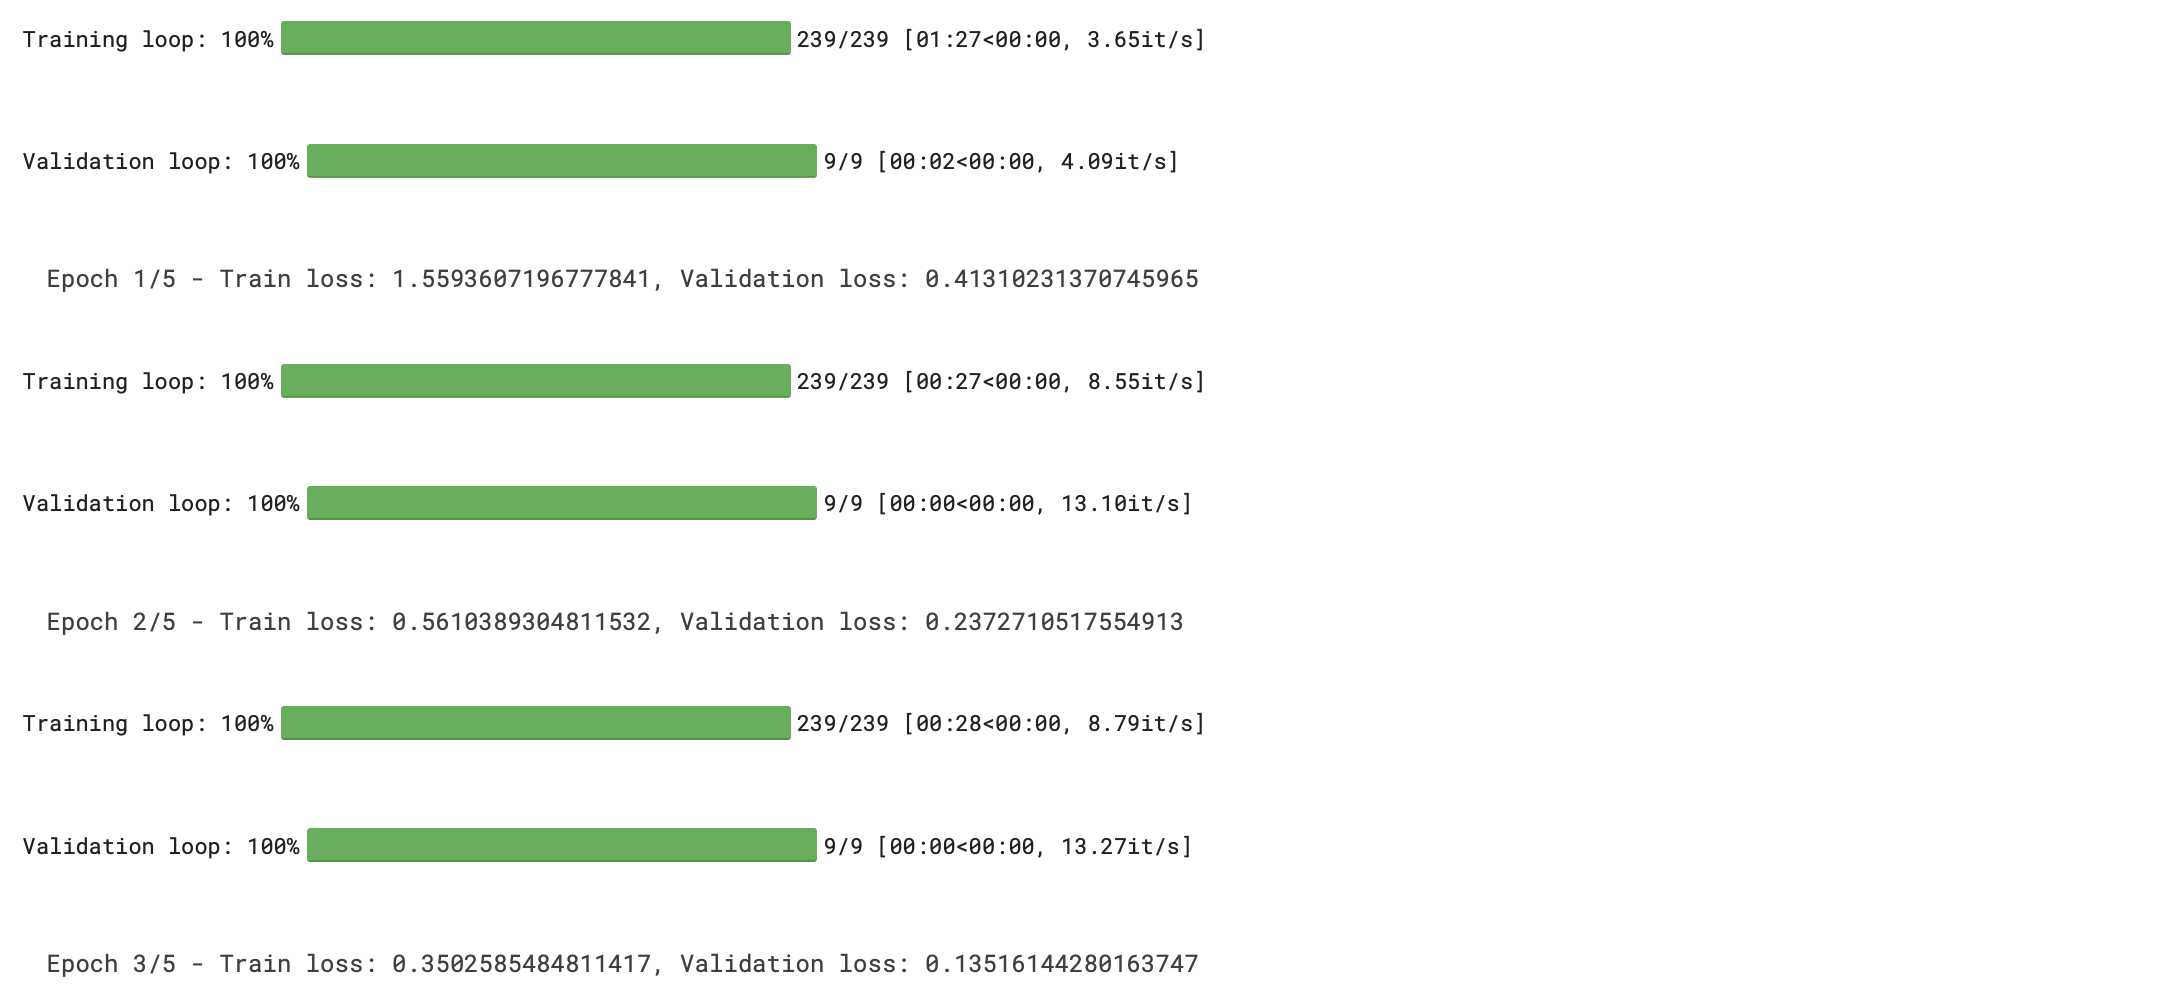

NOTE

We saw both training and validation loss decrease with each loop. YAY. 

If this didn’t happen, it would indicate overfitting to the training set.
- If training loss decreases but validation loss doesn't, the model is overfitting
- Overfitting is bad because the model memorizes the training data and performs poorly on new, unseen data

Recap of the training loop:
- Chose a loss function (criterion)
- Set an optimizer
- Created training and validation datasets
- Wrote the training loop: iterated over the training DataLoader and backpropagated losses
- At the end of each epoch, calculated validation loss

Through this process, I became familiar with PyTorch datasets, model creation, and training loops

Next: evaluate results visually by feeding in a test image


## Visualize Losses
We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is x! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

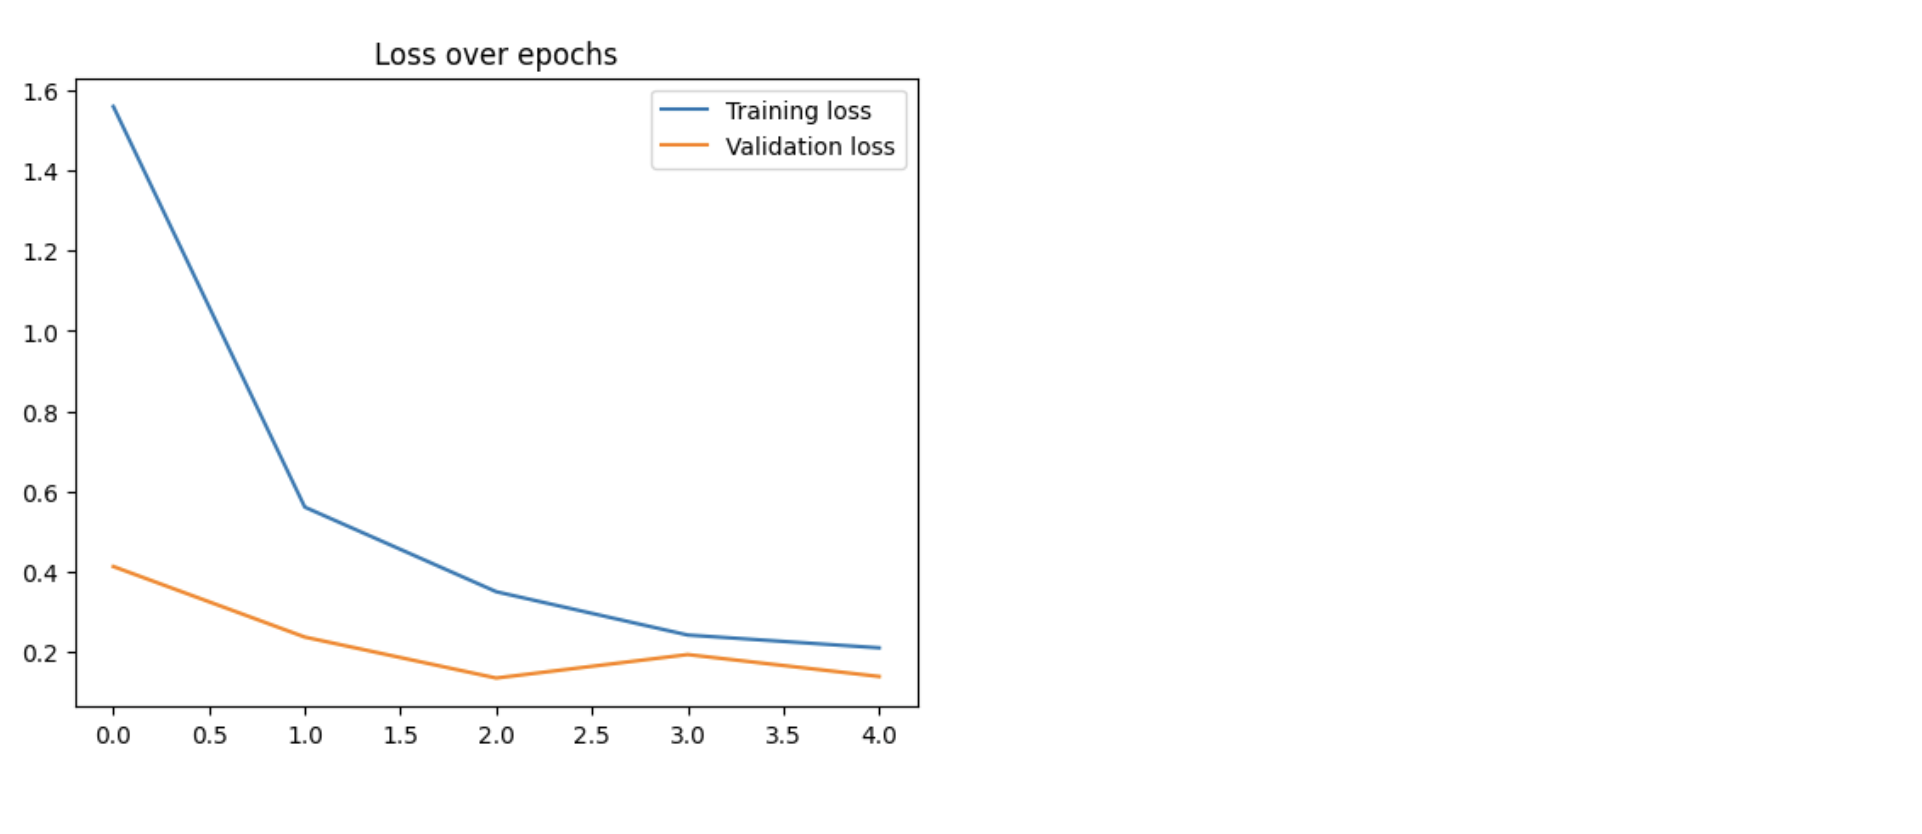

## Evaluating the Results

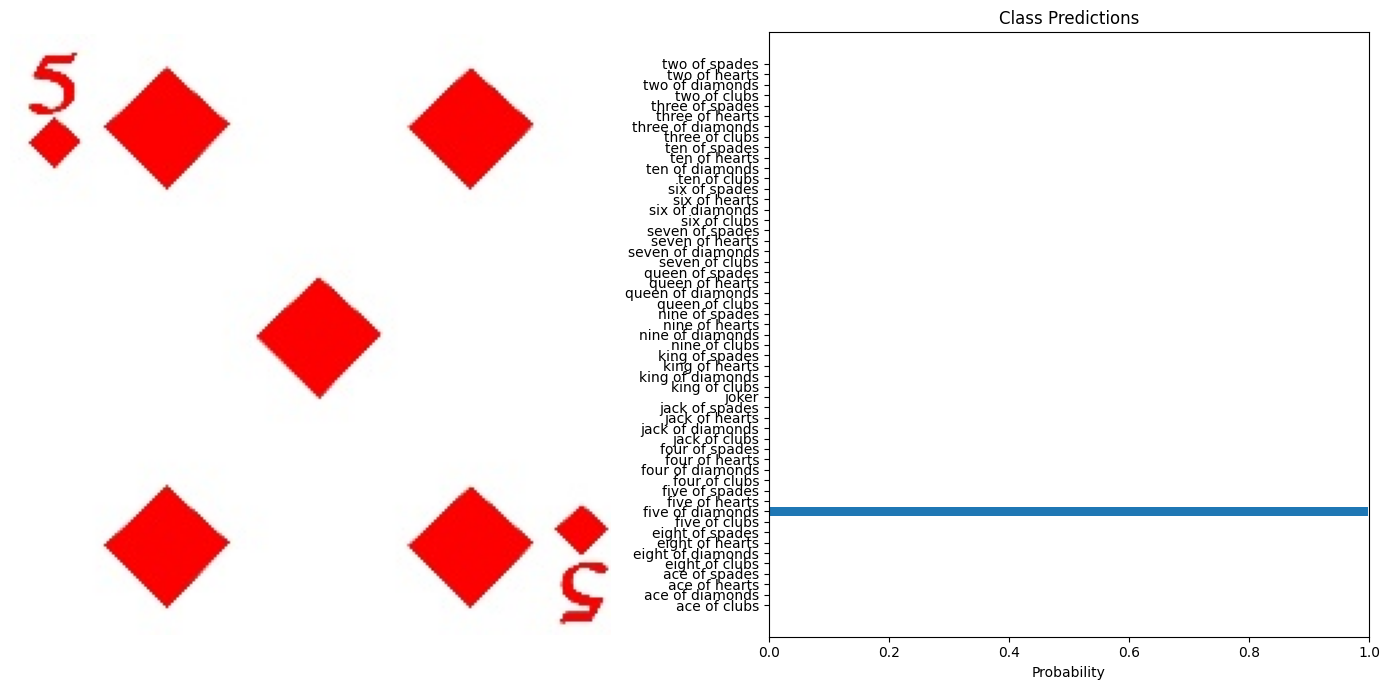

In [59]:
## Lets visualize what the predicitions look like from model when we feed it a test image
## Running code on an example text image (5 of diamonds)

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

Success! The model correctly predicts the image as the 5 of Diamonds

Next, we will try with 6 more test images to see how well it performs


In [ ]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 6)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

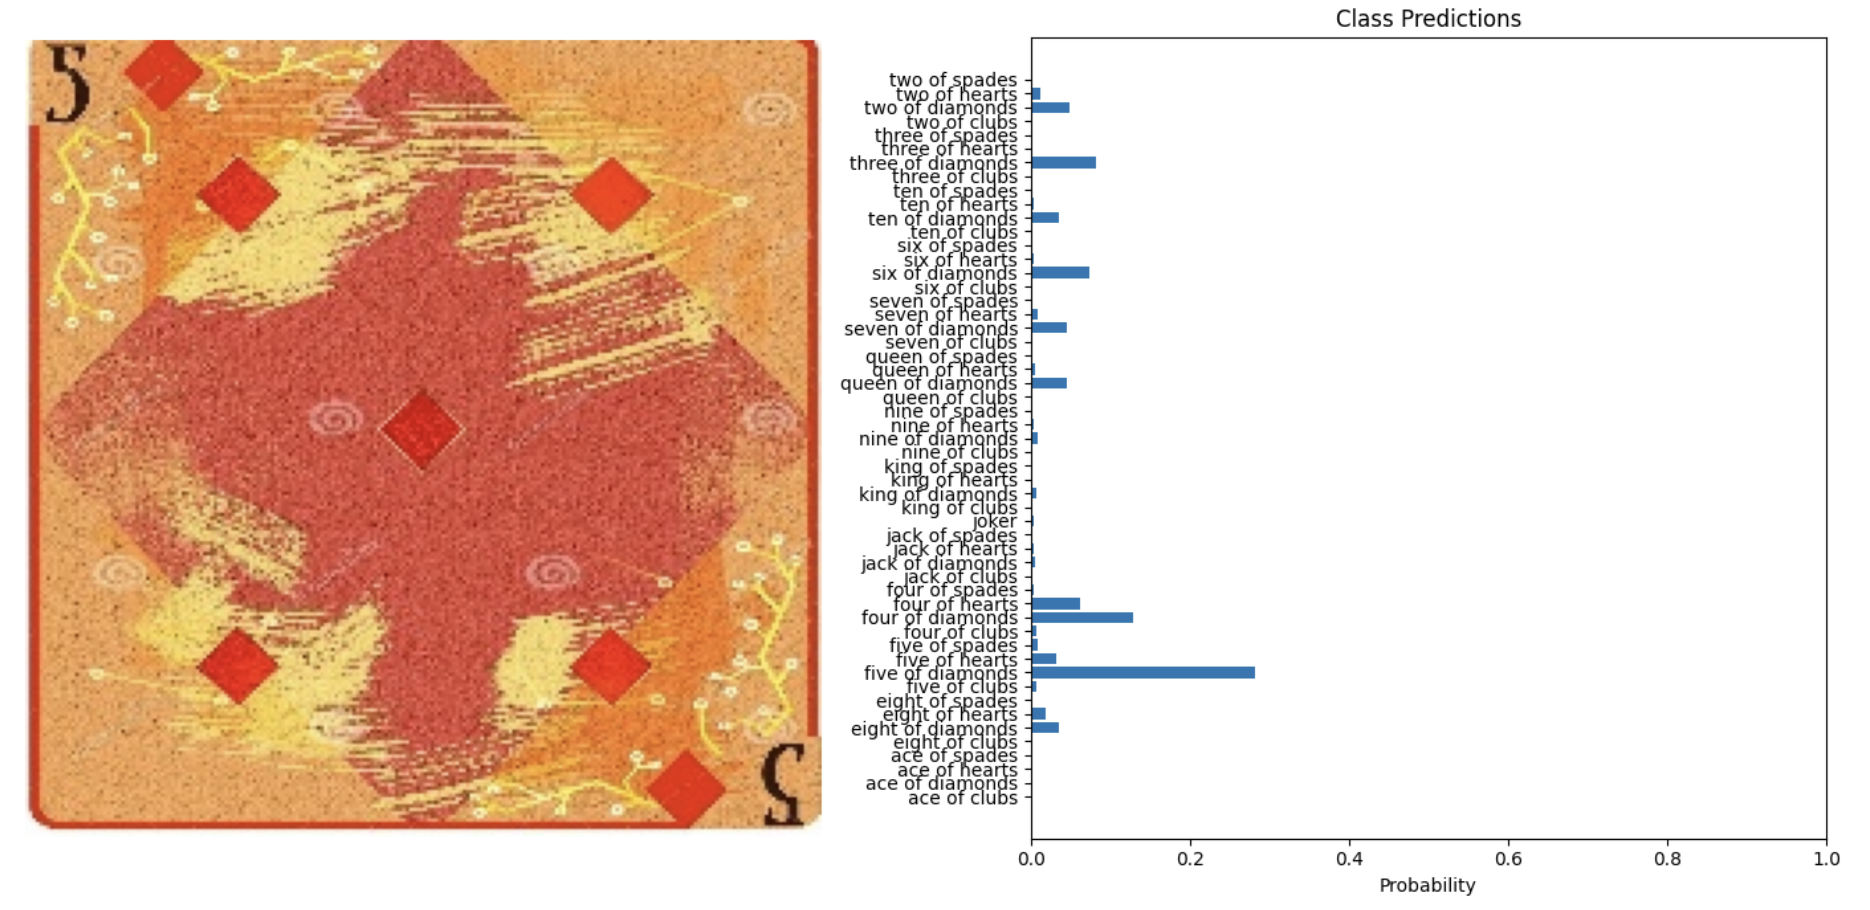

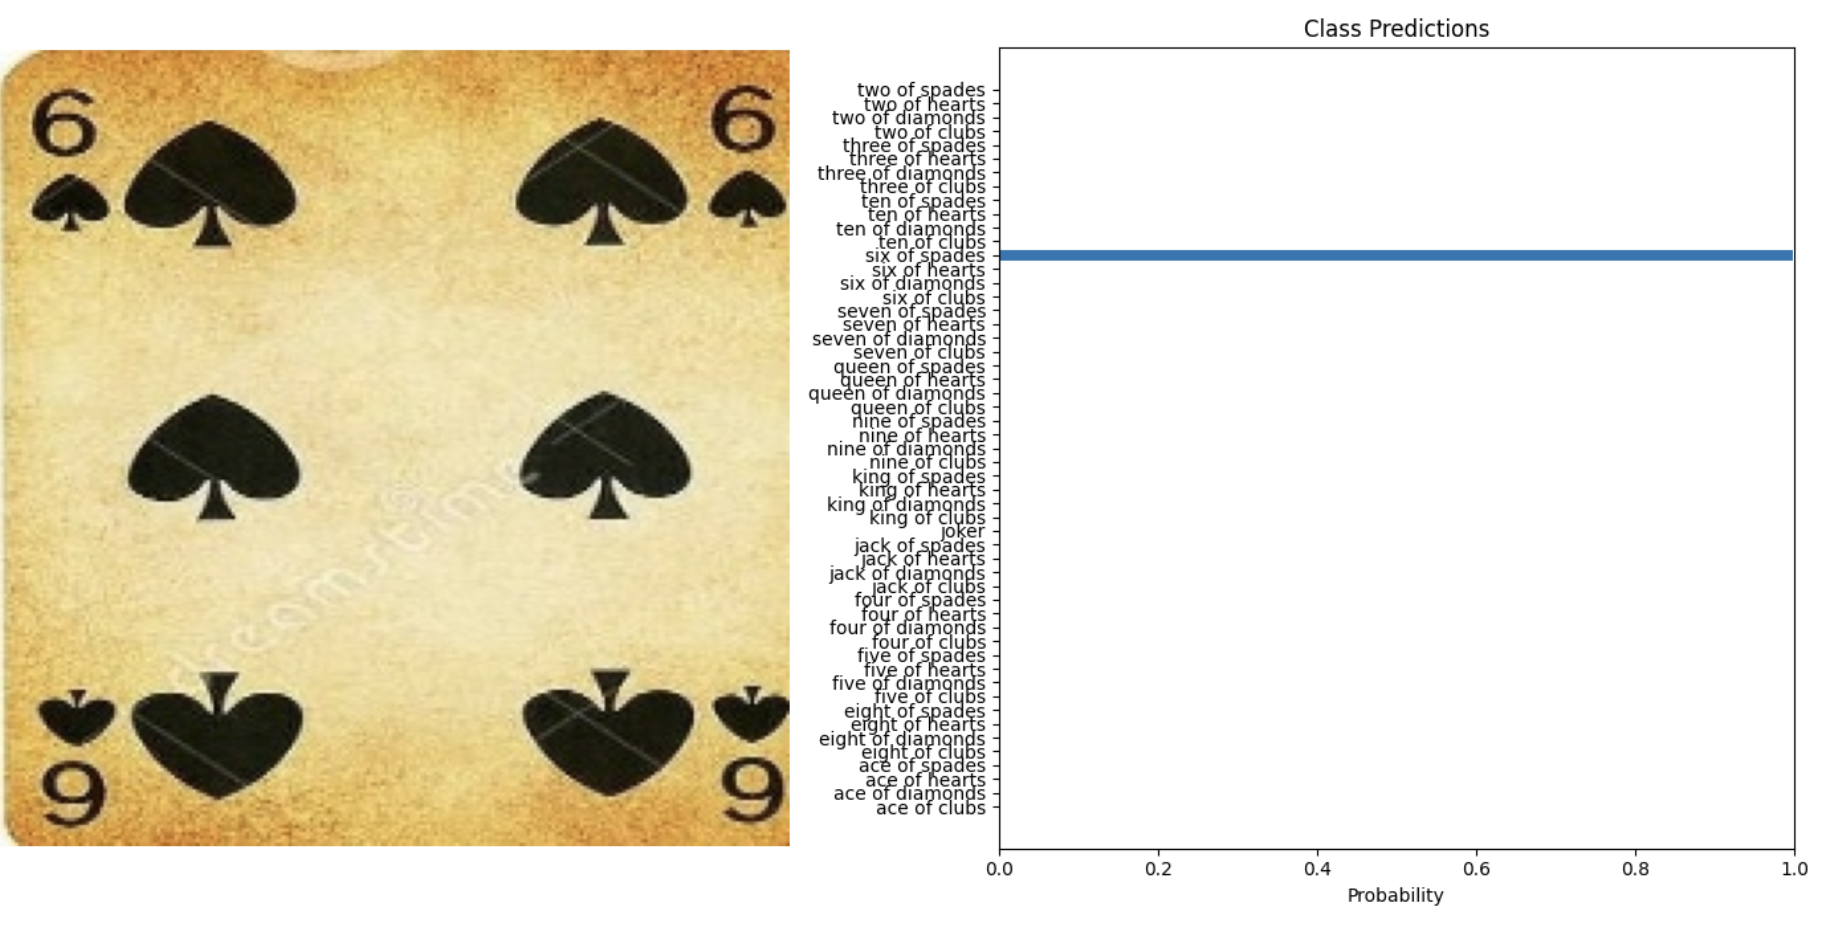

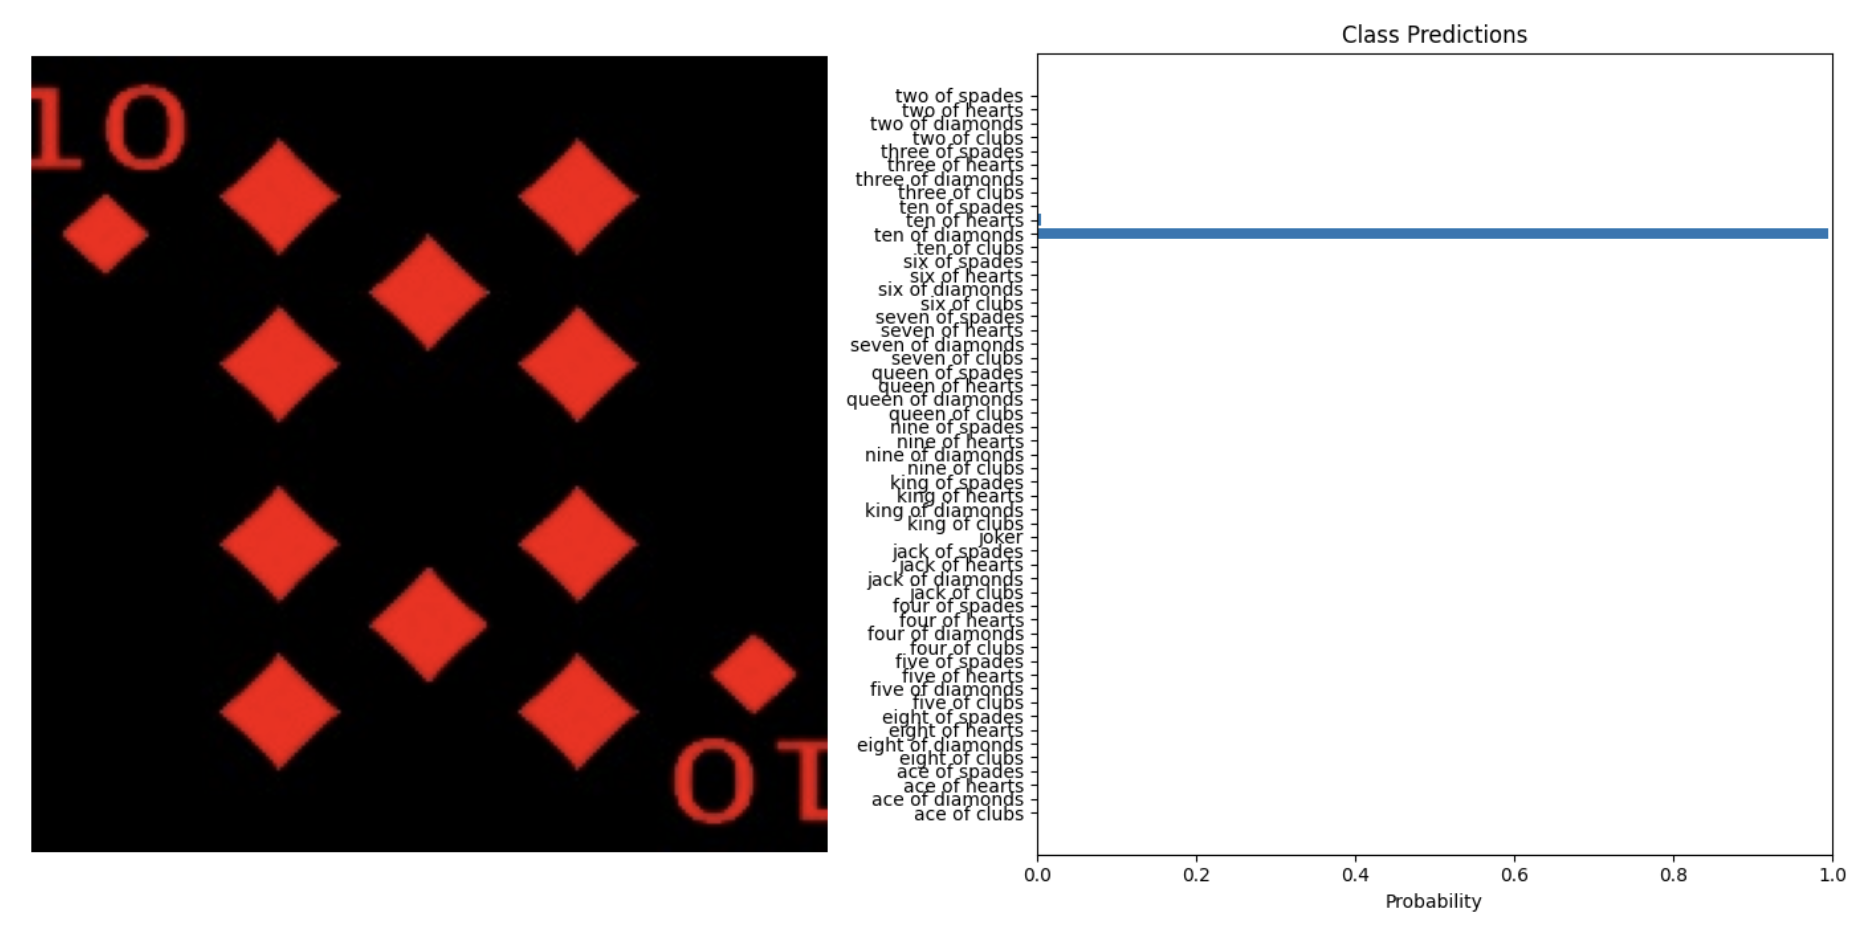

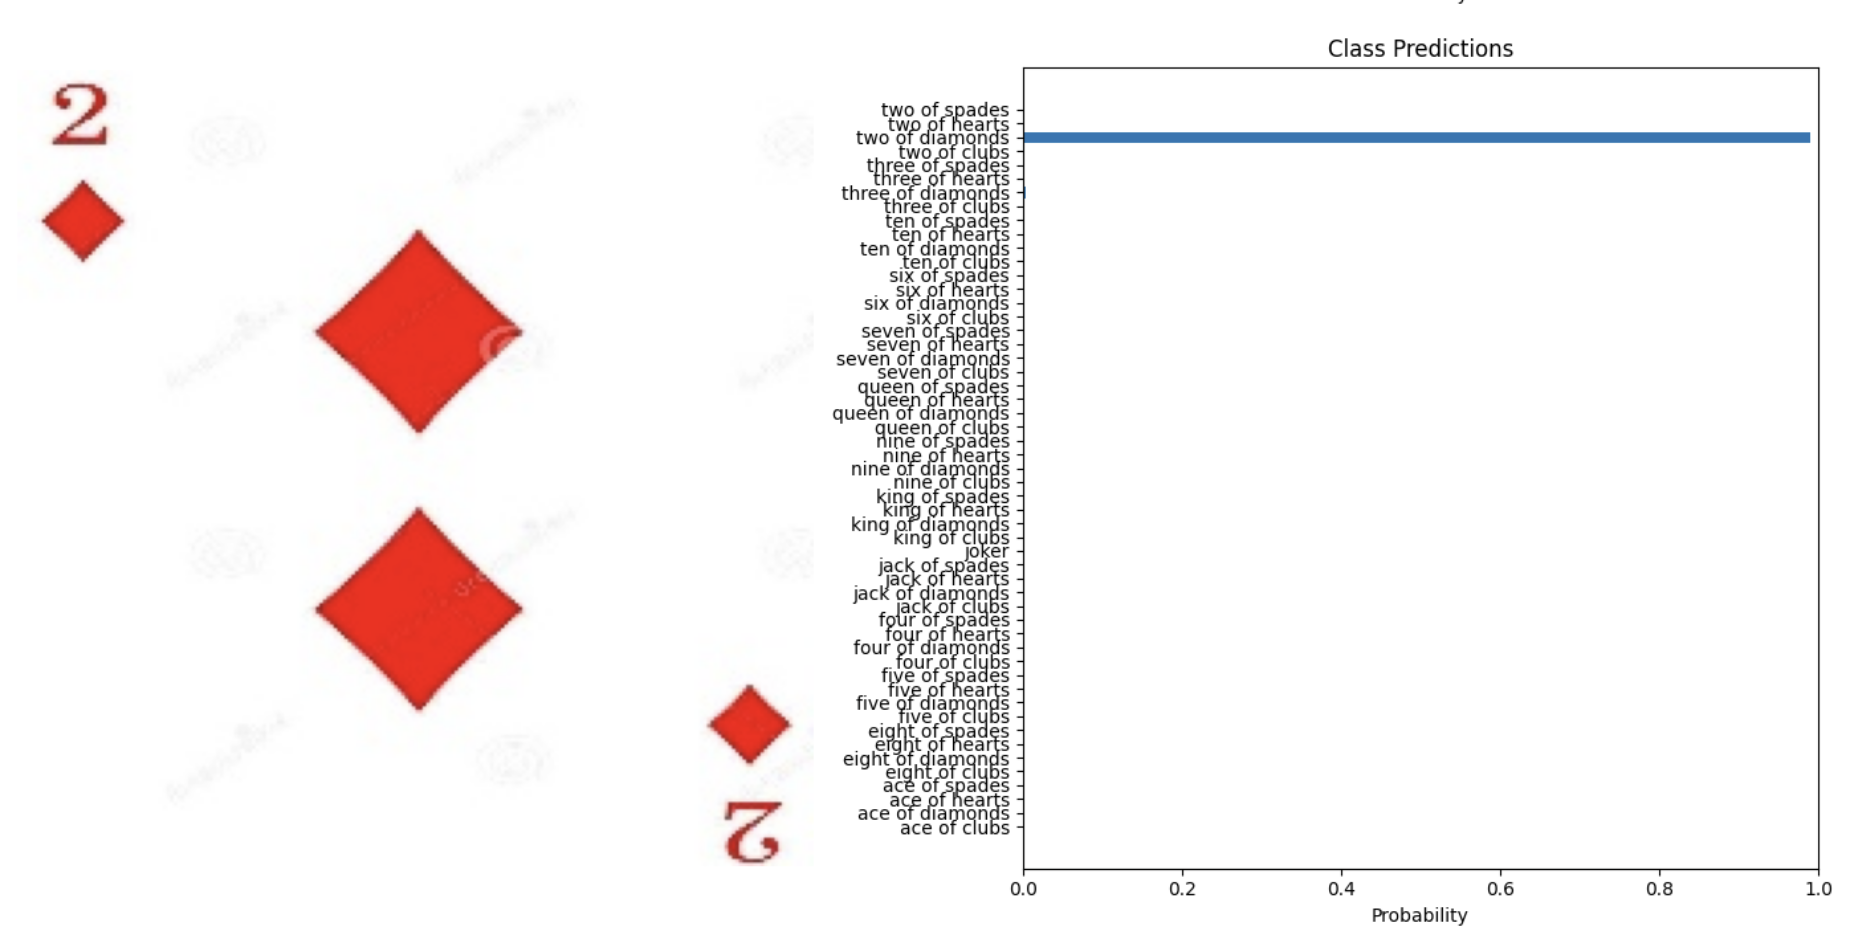

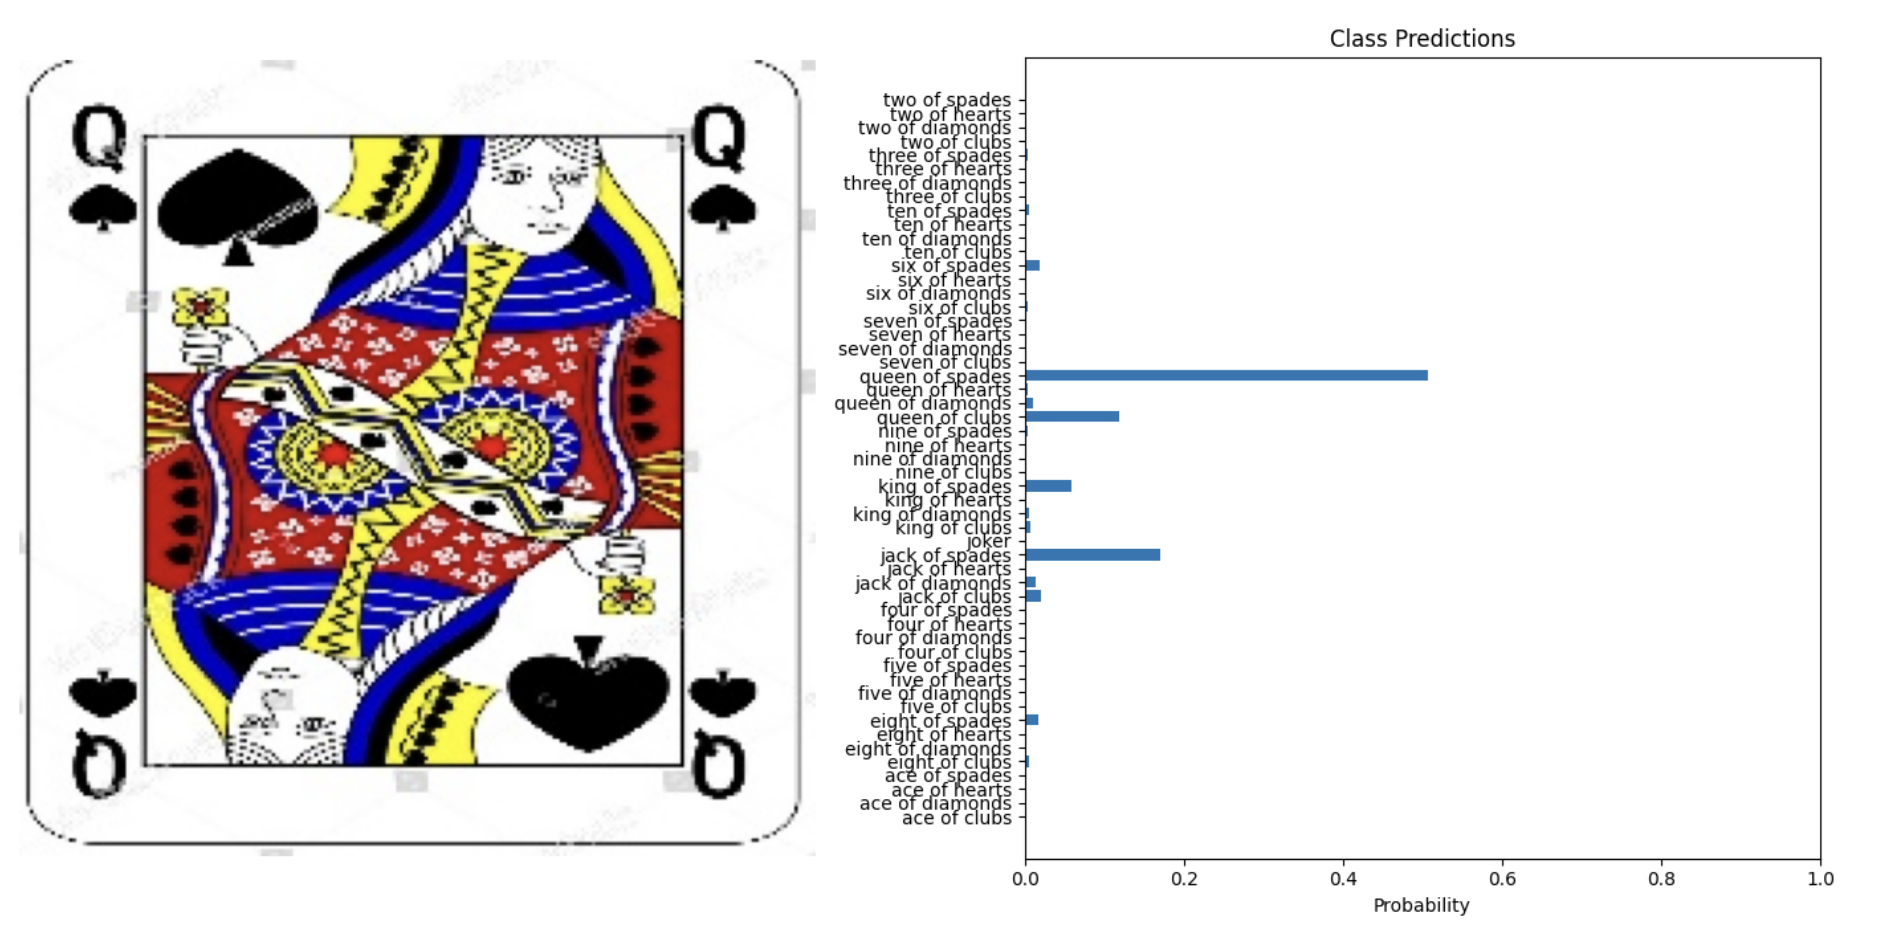

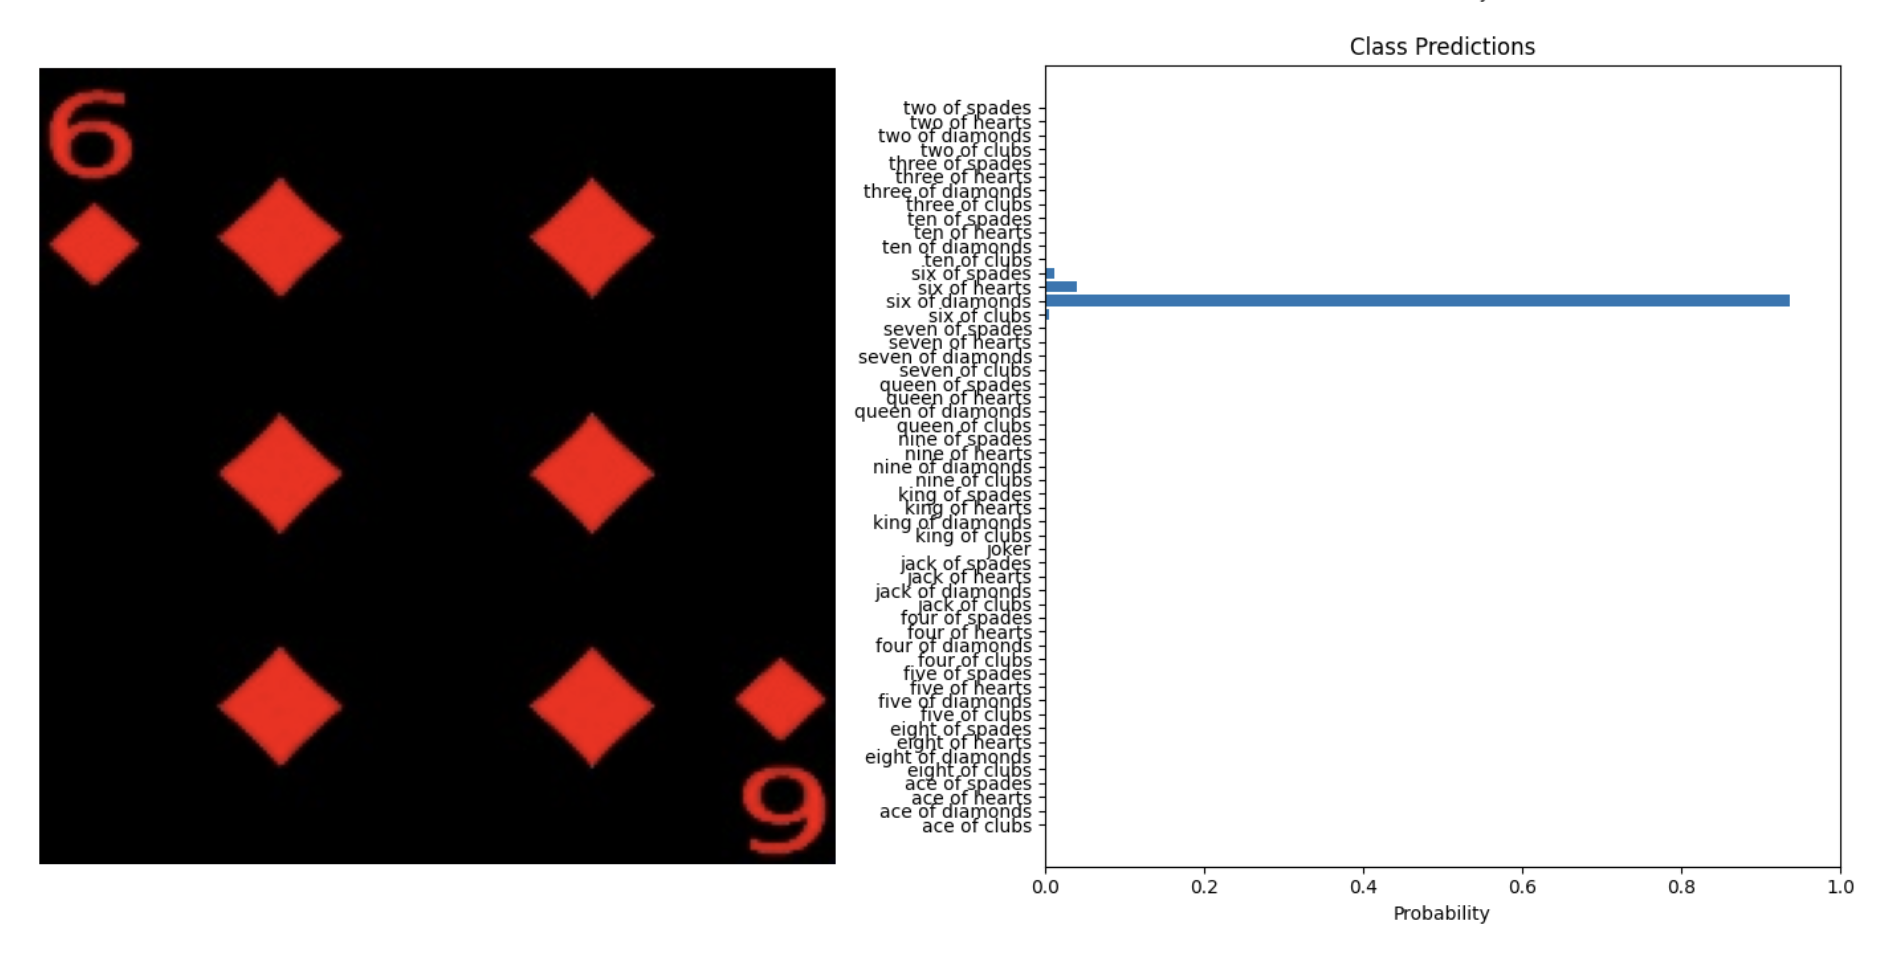

We see most predictions predicts the correct class!!

Note some images look different from the training data (ie standard clean deck of cards), so the model may struggle slightly.
For example, the first test image is a 5 of Diamonds but looks worn or unusual. Compare this to the very first test we did with a clean 5 of Diamonds card. 
Despite the change, the model still managed to predict the correct class, but from the graph we see it had to think a bit. 


## Next Steps

- We can apply ARG Max (post-processing technique) to identify highest class predicited.
- We can also calculate the accuracy of our model on the validation and test set.

